In [61]:
%matplotlib notebook
import pandas as pd
import os
from datetime import datetime

## Defining spark-rats exported info

In [62]:
export_path = "../export"
df_files = ["border_info.parquet","infecteds_history.parquet","infected_tiles.parquet"]

dates = os.listdir(export_path)
dates

['2020-07-27 05:20',
 '2020-07-27 05:19',
 '2020-07-27 05:41',
 '2020-07-27 05:16',
 '2020-07-27 05:17',
 '2020-07-27 05:21',
 '2020-07-27 05:40',
 '2020-07-27 05:45',
 '2020-07-27 05:42',
 '2020-07-27 05:44',
 '2020-07-27 05:15']

## Reading spark-rats data

In [63]:
date_file_format = '%Y-%m-%d %H:%M'

def df_info_to_dict(df):
    return df.T.to_dict()[0]

def read_stat_df(parquet_stat, date_dir, export_dir="../export"):
    parquet_dir = f"{export_dir}/{date_dir}/{parquet_stat}"
    
    # We need spark repartition to just one file on save stats data
    parquet_files = [f for f in os.listdir(parquet_dir) if f.endswith(".parquet")]
    df = pd.read_parquet(f"{parquet_dir}/{parquet_files[0]}")
    df['creation_date'] = datetime.strptime(d, date_file_format)
    
    # cast single row info dataframes to dict
    if len(df) == 1:
        df = df_info_to_dict(df)
    return df

In [64]:
simulations = {}
for d in dates:
    simulation_date = datetime.strptime(d, date_file_format)
    simulations[d] = {"date":simulation_date}
    for dff in df_files:
        simulations[d][dff] = read_stat_df(dff, d)

In [65]:
sims_dates = list(simulations.keys())
print("sim_dates:")
print(sims_dates)
print("\n")
print("df_files:")
print(df_files)

sim_dates:
['2020-07-27 05:20', '2020-07-27 05:19', '2020-07-27 05:41', '2020-07-27 05:16', '2020-07-27 05:17', '2020-07-27 05:21', '2020-07-27 05:40', '2020-07-27 05:45', '2020-07-27 05:42', '2020-07-27 05:44', '2020-07-27 05:15']


df_files:
['border_info.parquet', 'infecteds_history.parquet', 'infected_tiles.parquet']


In [66]:
simulations[sims_dates[3]]["border_info.parquet"]

{'min_latitude': 9.999086280043628,
 'max_latitude': 10.00091410005482,
 'min_longitude': 9.99909912638977,
 'max_longitude': 10.000900586728388,
 'min_tile_x': 0,
 'max_tile_x': 203,
 'min_tile_y': 0,
 'max_tile_y': 200,
 'total': 100000,
 'creation_date': Timestamp('2020-07-27 05:16:00')}

In [67]:
def max_sims_date():
    df = pd.DataFrame(sims_dates,columns=['simdate'])
    df['simdate_in_date'] = pd.to_datetime(df['simdate'], format=date_file_format)
    df = df.sort_values(by='simdate_in_date',ascending=False).reset_index()
    return list(df.simdate.values)[0]
last_simulation = simulations[max_sims_date()]

## Printing infected tiles

In [68]:
df = last_simulation["infected_tiles.parquet"]
df.head(3)

,tile_x,tile_y,infected,creation_date
0,148,173,1,2020-07-27 05:45:00
1,75,97,1,2020-07-27 05:45:00
2,113,16,1,2020-07-27 05:45:00


<IPython.core.display.Javascript object>


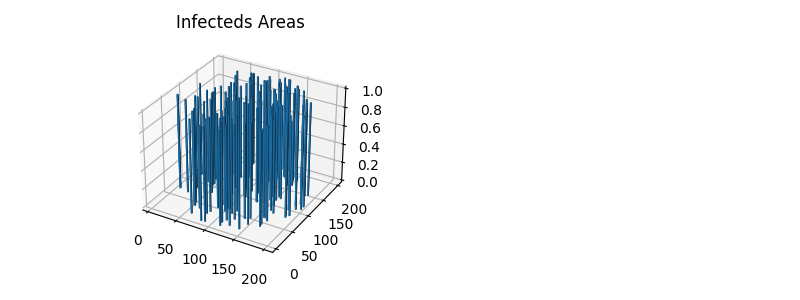

Text(0.5, 0.92, 'Infecteds Areas')

In [69]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')

x,y = df.tile_x, df.tile_y
top = df.infected
bottom = np.zeros_like(top)
width = depth = 2

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Infecteds Areas')

## Infected Tiles - evolution 

In [70]:
frames = []
for s in sims_dates:
    infected_tiles = simulations[s]["infected_tiles.parquet"]
    infected_tiles['creation_str'] = s
    frames.append(infected_tiles)
all_infected_tiles = pd.concat(frames).sort_values("creation_date",ascending=True).reset_index()

In [71]:
all_infected_tiles.head(3)

,index,tile_x,tile_y,infected,creation_date,creation_str
0,103,100,133,1,2020-07-27 05:15:00,2020-07-27 05:15
1,27,121,160,1,2020-07-27 05:15:00,2020-07-27 05:15
2,28,161,70,1,2020-07-27 05:15:00,2020-07-27 05:15


In [72]:
import plotly.express as px

all_infected_tiles['infected_px'] = all_infected_tiles.infected*1

px.scatter(all_infected_tiles, x="tile_x", y="tile_y", animation_frame="creation_str",
           size="infected_px", hover_name="infected",
            size_max=10, range_x=[0,200], range_y=[0,200])

## Infecteds Time evolution - total

In [73]:
infected_history = last_simulation['infecteds_history.parquet']
infected_history['infected_date'] = pd.to_datetime(infected_history['dateRep'], format=date_file_format)
infected_history = infected_history.sort_values(by='infected_date',ascending=True).reset_index()
infected_history

,index,dateRep,qty_infected,creation_date,infected_date
0,0,2020-07-26 05:14,100,2020-07-27 05:45:00,2020-07-26 05:14:00
1,9,2020-07-27 05:14,4,2020-07-27 05:45:00,2020-07-27 05:14:00
2,1,2020-07-27 05:16,4,2020-07-27 05:45:00,2020-07-27 05:16:00
3,3,2020-07-27 05:17,4,2020-07-27 05:45:00,2020-07-27 05:17:00
4,5,2020-07-27 05:19,5,2020-07-27 05:45:00,2020-07-27 05:19:00
5,4,2020-07-27 05:20,3,2020-07-27 05:45:00,2020-07-27 05:20:00
6,2,2020-07-27 05:21,3,2020-07-27 05:45:00,2020-07-27 05:21:00
7,7,2020-07-27 05:39,4,2020-07-27 05:45:00,2020-07-27 05:39:00
8,11,2020-07-27 05:41,3,2020-07-27 05:45:00,2020-07-27 05:41:00
9,6,2020-07-27 05:42,2,2020-07-27 05:45:00,2020-07-27 05:42:00


<IPython.core.display.Javascript object>


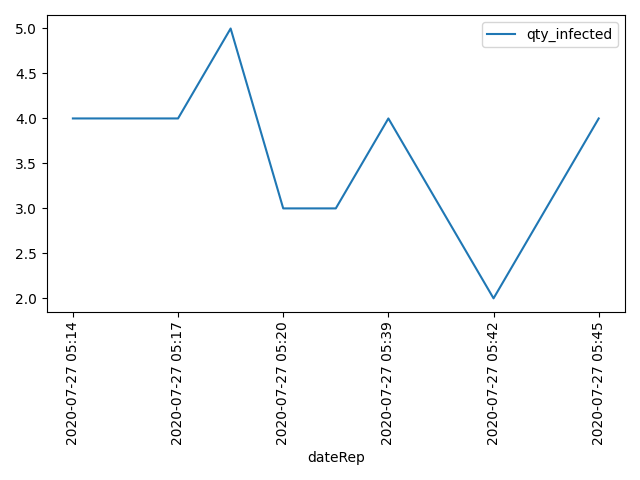

/home/chanchus/developments/sparkRats/analytics/venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [75]:
import matplotlib.pyplot as plt

infected_history.drop(0).plot.line(x='dateRep',y='qty_infected',rot=90)
plt.tight_layout()